# Tutorial 3, Question 2b

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import time
import numpy as np
import matplotlib.pylab as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

## Set learning parameters

In [2]:
no_epochs = 1000
batch_size = 16
lr = 0.1

SEED = 100
torch.manual_seed(SEED)
np.random.seed(SEED)

no_inputs = 4
no_outputs = 3

## Read input data

In [3]:
iris = datasets.load_iris()
iris.data -= np.mean(iris.data, axis=0)
    
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4, random_state=2)

print(np.shape(x_train))
print(np.shape(y_test))

(90, 4)
(60,)


In [4]:
class MyDataset(Dataset):
  def __init__(self, X, y):
    self.X =torch.tensor(X, dtype=torch.float)
    self.y =torch.tensor(y)
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self,idx):
    return self.X[idx], self.y[idx]

In [5]:
train_data = MyDataset(x_train, y_train)
test_data = MyDataset(x_test, y_test)

## Build the model

In [6]:
class SoftmaxLayer(nn.Module):
  def __init__(self, no_inputs, no_outputs):
        super().__init__()
        self.softmax_layer = nn.Sequential(
            nn.Linear(no_inputs, no_outputs),
            nn.Softmax(dim=1)
        )

  def forward(self, x):
        logits = self.softmax_layer(x)
        return logits

## Train the model

In [7]:
model = SoftmaxLayer(no_inputs, no_outputs)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param} \n")

Model structure: SoftmaxLayer(
  (softmax_layer): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): Softmax(dim=1)
  )
)


Layer: softmax_layer.0.weight | Size: torch.Size([3, 4]) | Values : Parameter containing:
tensor([[-0.3883,  0.3158, -0.2374, -0.0161],
        [ 0.1765,  0.2539, -0.2373, -0.4572],
        [-0.2920, -0.3820, -0.3783,  0.2356]], requires_grad=True) 

Layer: softmax_layer.0.bias | Size: torch.Size([3]) | Values : Parameter containing:
tensor([ 0.2118,  0.2876, -0.0817], requires_grad=True) 



In [8]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= size
    correct /= size
    return train_loss, correct
    

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
 
    return test_loss, correct
    

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

batch_sizes = [2, 4, 8, 16, 24, 32, 48, 64]

acc_, t_ = [], []

for batch_size in batch_sizes:
    model = SoftmaxLayer(no_inputs, no_outputs)
    
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)
    num_batches = len(train_dataloader)

    train_loss_, train_acc_, test_loss_, test_acc_ = [], [], [], []
    t = 0
    for epoch in range(no_epochs):
        start_time = time.time()
        train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)
        t += time.time() - start_time
        train_loss_.append(train_loss), train_acc_.append(train_acc)
        test_loss_.append(test_loss), test_acc_.append(test_acc)
    t_.append(t*1000/(no_epochs))
    acc_.append(test_acc_[-1])
    print(f"batch-size {batch_size} time {t_[-1]:>3f} accuracy {acc_[-1]:>2f}")
    

batch-size 2 time 23.629482 accuracy 0.683333
batch-size 4 time 12.995245 accuracy 0.766667
batch-size 8 time 7.739310 accuracy 0.250000
batch-size 16 time 4.660851 accuracy 0.183333
batch-size 24 time 3.636750 accuracy 0.016667
batch-size 32 time 2.951184 accuracy 0.400000
batch-size 48 time 2.439114 accuracy 0.133333
batch-size 64 time 2.256295 accuracy 0.550000


In [10]:
w = model.state_dict()['softmax_layer.0.weight'].numpy()
b = model.state_dict()['softmax_layer.0.bias'].numpy()

print('weight = {}, \nbias = {}'.format(w, b))

weight = [[ 0.47331363 -0.20486778 -0.1514796  -0.44686174]
 [ 0.04563153  0.48053175  0.01542509 -0.31577468]
 [-0.05543137 -0.32256472  0.47324187  0.12658691]], 
bias = [-0.30926228  0.15191352 -0.44959503]


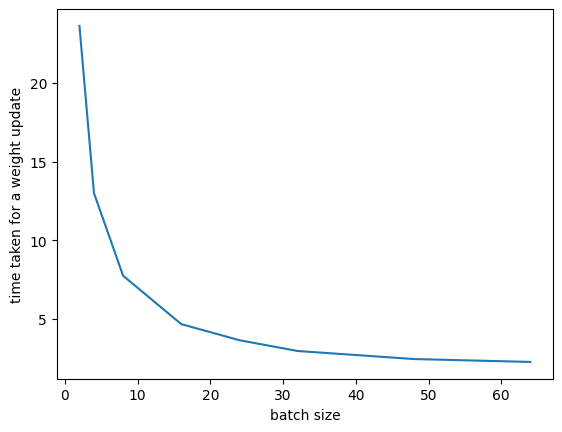

In [13]:
plt.figure(1)
plt.plot(batch_sizes, t_)
plt.xlabel('batch size')
plt.ylabel('time taken for a weight update')
plt.show()

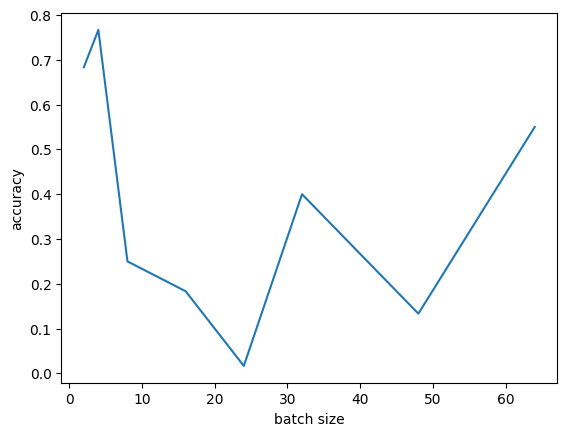

In [14]:
plt.figure(1)
plt.plot(batch_sizes, acc_)
plt.xlabel('batch size')
plt.ylabel('accuracy')
plt.show()

## Plot learning curves